# Programming Language Classification

<img src="image.png">

<br>
The purpose of this notebook is to predict the programming language based on the code snippet. I was provided with the data, which I need to understand, preprocess and use in the model. First I will import necessary  libraries <br><br>

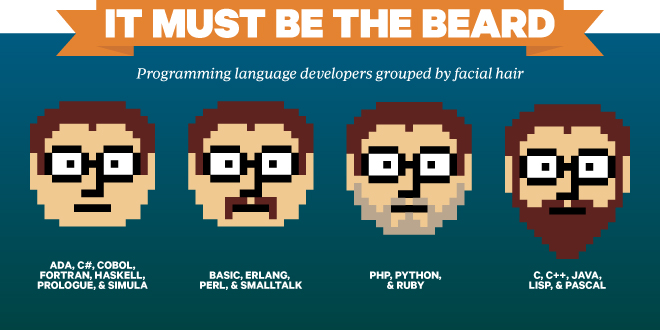

In [1]:
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import random
import numpy as np
random.seed(42)

# 	Exploratory Data Analysis

To understand the data, exploratory data analysis is needed. I will investigate the file provided along with patterns that can be found. First I will load the data and print 10 first columns.

In [2]:
languages = pd.read_csv('data/data.csv')

In [3]:
languages.head(10)

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...
5,JavaScript,10003,100006,"function divByZero(dividend,divisor)\n{\n\tvar..."
6,JavaScript,10004,100007,"if (""abs"" in Math) { ... }\n"
7,JavaScript,10004,100008,"if (typeof bloop !== ""undefined"") { ... }\n"
8,JavaScript,10005,100009,(function () {\n 'use strict';\n\n // di...
9,JavaScript,10005,100010,"function sort_disjoint(values, indices) {\n v..."


Each column describes one programming language along with project and file. Multiple files can belong to one project for a given language. Before jumping into a further investigation, I will check the basic information about columns.  

In [4]:
languages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16272 entries, 0 to 16271
Data columns (total 4 columns):
language     16272 non-null object
proj_id      16272 non-null int64
file_id      16272 non-null int64
file_body    16268 non-null object
dtypes: int64(2), object(2)
memory usage: 508.6+ KB


In [5]:
languages["language"].unique()

array(['JavaScript', 'Swift', 'Python', 'Java', 'C++', 'Ruby', 'Rust',
       'C', 'Scala', 'R', 'Go', 'Mathematica', 'Kotlin', 'Fortran',
       'Julia', 'PHP', 'MATLAB', 'Haskell', 'Perl'], dtype=object)

In [6]:
languages["language"].nunique()

19

The file contains 16272 code examples of 19 different programming languages printed above. 4 code snippets seems to be missing, I will investigate it further as it may cause a problem in the model. 

In [7]:
languages.isnull().any()

language     False
proj_id      False
file_id      False
file_body     True
dtype: bool

In [8]:
languages[languages.isnull().any(axis=1)]

,language,proj_id,file_id,file_body
1163,Swift,10518,101164,NaN
9951,Mathematica,15938,109952,NaN
12227,Julia,17632,112228,NaN
15290,Perl,19446,115291,NaN


As suspected, four code snippets are missing. As it is an irrelevant fraction of the whole dataset, I will delete those columns in order to prevent further problems. 

In [9]:
languages = languages.drop(languages.index[languages[languages.isnull().any(axis=1)].index.values])

### Files per project

I would like to see whether the number of files per project may be dependent on the programming language. I will group the dataset by proj_id and programming language to count a number of files per certain project. 

In [10]:
l = pd.DataFrame({'files_in_project' : languages.groupby(['proj_id','language']).size()}).reset_index()

In [11]:
l.head()

,proj_id,language,files_in_project
0,10001,JavaScript,2
1,10002,JavaScript,3
2,10003,JavaScript,1
3,10004,JavaScript,2
4,10005,JavaScript,3


In [12]:
l['files_in_project'].describe()

count    10006.000000
mean         1.625825
std          1.304016
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         41.000000
Name: files_in_project, dtype: float64

In general the number of files varies between 1 and 2, however, max value is 41. I will plot the 10 biggest values to investigate it further. 

In [13]:
l.nlargest(10, 'files_in_project')

,proj_id,language,files_in_project
7401,17404,Fortran,41
9272,19276,Haskell,19
886,10888,Python,15
1156,11158,Python,14
1362,11364,Python,14
8928,18932,Haskell,14
8251,18255,PHP,13
65,10066,JavaScript,12
452,10453,JavaScript,12
539,10541,Swift,12


Fortran is the programming language that has the most files in one project in this dataset, followed by Haskell, Python, PHP, JavaScript and Swift. However, from the graph above Haskell can be treated as a programming language with the most extensive architecture, it is impossible to tell it for sure. Further hypothesis estimation is needed to prove that it is 
statistically significant 
<br>

I will now plot the files_in_project histograms for every language to get a better sense of the distribution of this feature.

In [14]:
l.hist(column = 'files_in_project', figsize=(20,10), grid=False, layout=(4,5), bins = 30, by = 'language', sharex = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247C3FA8C88>,
      dtype=object)

From the first glance it can be seen that there are outliers for almost every programming language and to be able to be more precise it would be needed to delete them. 

However, some pattern can be taken out from the  histograms:

    - Most of the programming languages have a similar distribution of files per project 
    - Python is highly condensed around 0-5 projects
    - JavaScript seems to have a higher number of files per project than other popular programming languages
    - Haskell is showing a similar distribution to Python
    - Kotlin has the biggest proportion of one file per project
    - The highest number of project for Fortran seems to be an outlier.
 

In [15]:
l = l[l['files_in_project'] < 40]
l['files_in_project'].describe()

count    10005.000000
mean         1.621889
std          1.243239
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: files_in_project, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247C5314A90>,
      dtype=object)

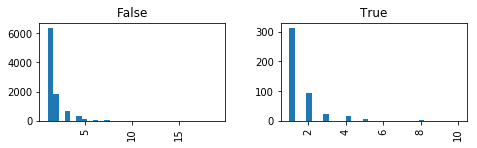

In [16]:
l.hist(column = 'files_in_project', figsize=(20,10), grid=False, layout=(4,5), bins = 30, by = l['language'] == 'Fortran')

After deleting outlier Fortran shows a distribution similar to other programming languages
<br>
<br>
Next, I would want to perform a similar analysis for the code length
### Lines per snippet

In [17]:
languages.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


In [18]:
languages["snippet_length"] = languages["file_body"].apply(len)
languages.head()

,language,proj_id,file_id,file_body,snippet_length
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...,411
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...,493
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...,400
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n",30
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...,1346


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247BB8CE8D0>,
      dtype=object)

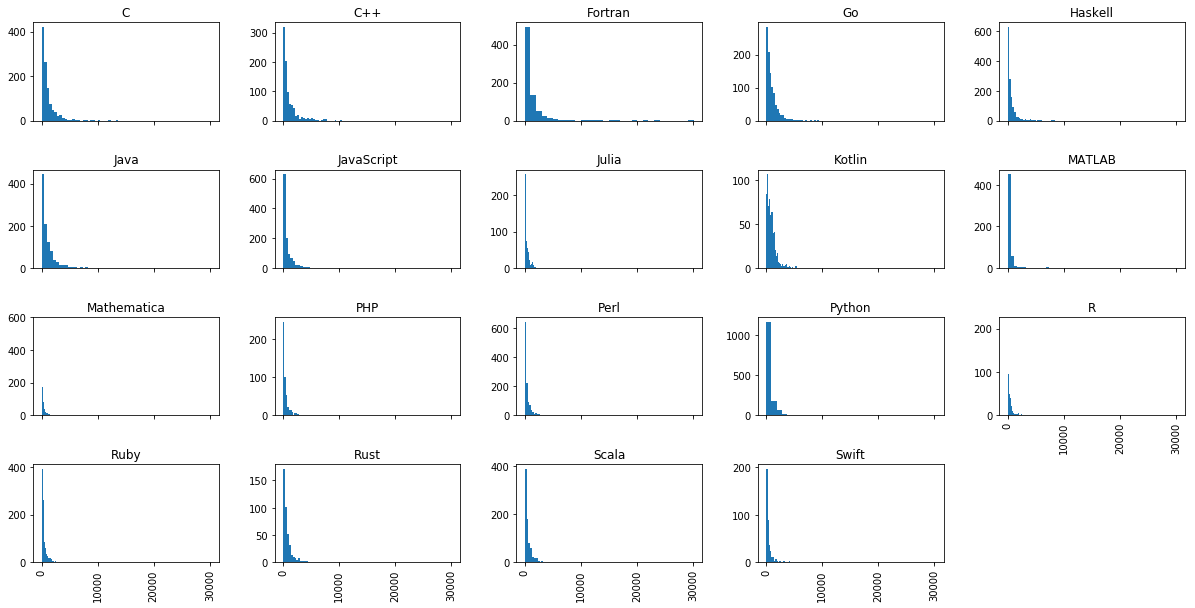

In [19]:
languages.hist(column = 'snippet_length', figsize=(20,10), grid=False, layout=(4,5), bins = 30, by = 'language',sharex = True)

As previously histograms may be unprecise due to outliers and further analysis should focus on deleting them. It is possible however to see that:

    - C, C++, Fortran, Go, Kotlin are the languages that take the most code
    - Other languages are showing a similar distribution
    - High distribution for Kotlin may be caused by the previous founding that there is usually only one file per project for this language

### Printing code examples

In [20]:
temp = languages.loc[:, ["language", "file_body"]].drop_duplicates(subset=['language'])
for row_no in range(temp.shape[0]):
    print(temp.iloc[row_no, :]["language"] + "\n")
    print(temp.iloc[row_no, :]["file_body"])
    print("*"*80)

JavaScript

// Functions as values of a variable
var cube = x => Math.pow(x, 3);

var cuberoot = x => Math.pow(x, 1 / 3);


// Higher order function
var compose = (f, g) => (x => f(g(x)));

// Storing functions in a array
var fun = [ Math.sin, Math.cos, cube ];
var inv = [ Math.asin, Math.acos, cuberoot ];

for (var i = 0; i < 3; i++) {
  // Applying the composition to 0.5
  console.log(compose(inv[i], fun[i])(0.5));
}

********************************************************************************
Swift

import Darwin
func compose<A,B,C>(f: (B) -> C, g: (A) -> B) -> (A) -> C {
  return { f(g($0)) }
}
let funclist = [ { (x: Double) in sin(x) }, { (x: Double) in cos(x) }, { (x: Double) in pow(x, 3) } ]
let funclisti = [ { (x: Double) in asin(x) }, { (x: Double) in acos(x) }, { (x: Double) in cbrt(x) } ]
println(map(zip(funclist, funclisti)) { f, inversef in compose(f, inversef)(0.5) })

********************************************************************************
Python

>>> # Some 

# Bag of words

Bag-of-words is a statistical language model based on word count used is NLP. One of the most common ways to implement the BoW model in Python is as dictionary witch each key set to a word and each value set to the number of times that word appears. For example: 

       "I like machine learning as much as I like pizza" 
     
      {I:2,like:2,machine:1, learning:1, as:2, much:1, pizza:1}

The words from the sentence go into the bag-of-words and come out as a dictionary of words with their corresponding counts. For statistical models, we call the text that we use to build the model for, our training data. 

In [21]:
def preprocess_text(text):
  cleaned = re.sub(r'\W+', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  return tokenized

In [22]:
text = "I like machine learning as much as I like pizza" 
text_tokenized = preprocess_text(text)
text_tokenized

['i', 'like', 'machine', 'learning', 'as', 'much', 'as', 'i', 'like', 'pizza']

In [23]:
def text_to_bow(some_text):
  bow_dictionary = {}
  tokens = some_text
  for token in tokens:
    if token in bow_dictionary:
      bow_dictionary[token] += 1
    else: 
      bow_dictionary[token] = 1
  return bow_dictionary

In [24]:
print(text_to_bow(text_tokenized))

{'i': 2, 'like': 2, 'machine': 1, 'learning': 1, 'as': 2, 'much': 1, 'pizza': 1}


Dictionary in generall is a very basic concept and commonly feature vector is used instead. A feature vector is a numeric representation of an item's important features. Each feature has its own column. If the feature exists for the item, it could be represented with a 1. If the feature does not exist for that item, it could be represented with a 0. 

To assign a vector index to a certain word feature dictionary is needed. 

For example, with "Five fantastic fish flew off to find faraway functions. Maybe find another five fantastic fish?" dictionary might be:

    {'five': 0,
    'fantastic': 1,
    'fish': 2,
    'fly': 3,
    'off': 4,
    'to': 5,
    'find': 6,
    'faraway': 7,
    'function': 8,
    'maybe': 9,
    'another': 10}

Using this dictionary, we can convert new documents into vectors using a vectorization function. For example, we can take a brand new sentence "Another five fish find another faraway fish." — test data — and convert it to a vector that looks like:


       [1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2]

In [25]:
def create_features_dictionary(documents):
  features_dictionary = {}
  merged = " ".join(documents)
  tokens = preprocess_text(merged)
  index = 0
  for token in tokens:
    if token not in features_dictionary:
      features_dictionary[token] = index
      index += 1
  return features_dictionary

In [26]:
training_documents = ["Five five five  fantastic fish flew off to find faraway functions.", 
                      "Maybe find another five fantastic fish?"]

In [27]:
feature_dictionary = create_features_dictionary(training_documents)
feature_dictionary

{'five': 0,
 'fantastic': 1,
 'fish': 2,
 'flew': 3,
 'off': 4,
 'to': 5,
 'find': 6,
 'faraway': 7,
 'functions': 8,
 'maybe': 9,
 'another': 10}

In [28]:
def text_to_bow_vector(some_text,features_dictionary):
  bow_vector = len(features_dictionary) * [0]
  tokens = preprocess_text(some_text)
  for token in tokens:
    feature_index = features_dictionary[token]
    bow_vector[feature_index] += 1
  return bow_vector

In [29]:
text = "Another five fish find another faraway fish"

In [30]:
print(text_to_bow_vector(text, feature_dictionary))

[1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2]


To build preprocess function I was using tokenize function from nltk library, however, CountVectorize function from sklearn library will do it for us.

# Models

In [31]:
X, y = languages['file_body'], languages['language']

I will use train_test_split from sklearn library to split the dataset into training and test set. 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0) 

### Code cleaning

In order to vectorize the text as showed above it is first important to clean and tokenize text. In NLP there are many techniques that are used to normalize text, like for example:
    - steamming: removing word prefixes. "shouting" may become "shout" 
    - lemmatization: bringing words down to their root forms. "Am", "Are" become "be"
    - stop words removal

I believe that those techniques are not necessary for the given problem. For programming languages, I know instructions are written in the same grammar form ('print', 'while', 'for'). However, it could be a topic for further investigation. 

Another technique used in NLP is TF-IDF (TF – term frequency, IDF – inverse document frequency). It measures the frequency of a character in the sequence and lowers the importance of those that are frequently used to be able to more precisely focus on things that can be crucial for classification.

For example when I would want to predict whether a certain article  is space related or not I would want to focus on terms like:     
    
    "Mars', "planet', 'earth', 'universe' 

Rather than words that are commonly used in other articles. 

I will not use TF-IDF in my model, however, it may be used in the further investigation.

I decided, however, to use ngrams as instructions in programming languages are used to be a set of words. 

    ngrams is simply a sequence of n words:
    
    'Sunny day' is an 2-gram
    
    'Beautiful sunny day' is an 3-gram
    
So finding instructions like for example in Java - System.out.println() may be crucial for the classification.


### Finding the cleaning pattern

In [33]:
X_train_list = X_train.tolist()

In [34]:
text = X_train_list[4]

In [35]:
print(text)

=head1 Obtaining perl

On the majority of UNIX and UNIX-like operating systems
(Linux, Solaris, AIX, HPUX, et cetera), perl will already be installed.
Mac OS X also ships with perl.
Note that "Perl" refers to the language
while "perl" refers to the interpreter used to run Perl programs.

Windows does not ship with perl. Instead, you will have to install one of
the following perl distributions:

=over 4

=item Strawberry Perl

L<Strawberry Perl|http://strawberryperl.com/>: A 100% Open Source Perl for
Windows that is exactly the same as Perl everywhere else; this includes using
modules from CPAN, without the need for binary packages.

=item DWIM Perl for Windows

L<DWIM Perl for Windows|http://dwimperl.com/windows.html>: A 100% Open Source
Perl for Windows, based on Strawberry Perl.
It aims to include as many useful CPAN modules as possible.

=item ActiveState Perl

L<http://www.activestate.com/activeperl/downloads>

=back

Links and further instructions on installation can be found on
L

In [36]:
def preprocess_text(text):
  cleaned = re.sub(r'\w{2,}|\s{2,}|[^\w\d\s]', ' ', text).lower()
  tokenized = word_tokenize(text)
  return tokenized

In [37]:
clean = preprocess_text(text)

In [38]:
print(clean)

['=head1', 'Obtaining', 'perl', 'On', 'the', 'majority', 'of', 'UNIX', 'and', 'UNIX-like', 'operating', 'systems', '(', 'Linux', ',', 'Solaris', ',', 'AIX', ',', 'HPUX', ',', 'et', 'cetera', ')', ',', 'perl', 'will', 'already', 'be', 'installed', '.', 'Mac', 'OS', 'X', 'also', 'ships', 'with', 'perl', '.', 'Note', 'that', '``', 'Perl', "''", 'refers', 'to', 'the', 'language', 'while', '``', 'perl', "''", 'refers', 'to', 'the', 'interpreter', 'used', 'to', 'run', 'Perl', 'programs', '.', 'Windows', 'does', 'not', 'ship', 'with', 'perl', '.', 'Instead', ',', 'you', 'will', 'have', 'to', 'install', 'one', 'of', 'the', 'following', 'perl', 'distributions', ':', '=over', '4', '=item', 'Strawberry', 'Perl', 'L', '<', 'Strawberry', 'Perl|http', ':', '//strawberryperl.com/', '>', ':', 'A', '100', '%', 'Open', 'Source', 'Perl', 'for', 'Windows', 'that', 'is', 'exactly', 'the', 'same', 'as', 'Perl', 'everywhere', 'else', ';', 'this', 'includes', 'using', 'modules', 'from', 'CPAN', ',', 'without'

# Naive Bayes

In [39]:
cv = CountVectorizer()

In [40]:
baye_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=r'\w{2,}|\s{2,}|[^\w\d\s]',ngram_range = (1,2))),
                      ('classifier', MultinomialNB())])

baye_pipe.fit(X_train, y_train)
baye_pipe.named_steps['vectorizer'].transform(X_train)

score_train = baye_pipe.score(X_train, y_train)
score_test = baye_pipe.score(X_test, y_test)
print("mean accuracy train: ", score_train)
print("mean accuracy test: ", score_test)

mean accuracy train:  0.9182418933456278
mean accuracy test:  0.8408113091579594


The score for the training set is higher than for the test set, meaning the model may be overfitting. I will try to tune the parameters to see if will optimize the model. Also, I decided to use the max_df argument from CountVectorizer(): 

 description from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


    max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if the vocabulary is None.


so max_df = 0.40 means "ignore terms that appear in more than 40% of the documents". Id decided to not use TF-IDF, however, signs like "(", ";", "<" etc. may cause a distraction in the model, so it would be better to check whether it may increase the outcome of the model. 

In [41]:
parameters = {
    'vectorizer__max_df': (0.2, 0.35, 1),
    'vectorizer__ngram_range': ((1, 3), (2, 2),(2,3),(3,3)),
    'classifier__alpha': (0.125, 0.01, 0.015),
}

In [42]:
grid_search = GridSearchCV(baye_pipe, parameters, n_jobs=-1, verbose=1) #on default cross-validation = 3

In [43]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\miksa\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), prepro...one, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vectorizer__max_df': (0.2, 0.35, 1), 'vectorizer__ngram_range': ((1, 3), (2, 2), (2, 3), (3, 3)), 'classifier__alpha': (0.125, 0.01, 0.015)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [44]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	classifier__alpha: 0.125
	vectorizer__max_df: 0.35
	vectorizer__ngram_range: (2, 2)


Suspicions both for max_df and ngrams turned out to be correct.

In [45]:
score_train = grid_search.score(X_train, y_train)
score_test = grid_search.score(X_test, y_test)
print("mean accuracy train: ", score_train)
print("mean accuracy test: ", score_test)

mean accuracy train:  0.9766405409558937
mean accuracy test:  0.9139520590043024


The model is still slightly overfitting, however, the score increased significantly. To make sure it is correct it is needed to evaluate precision, recall and f-score.

<br>

### Precision, Recall and F-score

In [46]:
prediction = grid_search.predict(X_test)
print(precision_recall_fscore_support(y_test, prediction, average="weighted"))

(0.9147578236565869, 0.9139520590043024, 0.9135502122686985, None)


### Printing the correct and misclassified languages 

In [52]:
score = grid_search.score(X_test, y_test)
print("mean accuracy: ", score, "\n")
print("PREDICTION :: ACTUAL")
for pair in zip(prediction, y_test):
    print("{} :: {}".format(pair[0], pair [1]))

mean accuracy:  0.9139520590043024 

PREDICTION :: ACTUAL
Ruby :: Ruby
Scala :: Scala
C :: C
Python :: Python
C++ :: C++
Mathematica :: Mathematica
Ruby :: Ruby
Perl :: Perl
Perl :: Perl
Julia :: Julia
Perl :: Perl
C :: C
Go :: Go
Ruby :: Ruby
C :: C
Rust :: Rust
Kotlin :: Kotlin
Scala :: Scala
Mathematica :: Mathematica
C++ :: C++
Perl :: Perl
Python :: Python
PHP :: PHP
Mathematica :: Mathematica
C++ :: C++
Julia :: Julia
C :: C
C++ :: C++
R :: R
Go :: Go
Kotlin :: Python
Python :: Python
Go :: Go
MATLAB :: MATLAB
Fortran :: Fortran
Python :: Python
JavaScript :: JavaScript
Perl :: Perl
JavaScript :: JavaScript
JavaScript :: JavaScript
Python :: Python
Scala :: Scala
Julia :: R
Julia :: Julia
Rust :: Rust
Scala :: Scala
Julia :: Julia
MATLAB :: Julia
Rust :: Rust
Python :: R
Rust :: Rust
C++ :: C++
Python :: Python
Mathematica :: Ruby
C :: C
Perl :: Perl
JavaScript :: JavaScript
Scala :: Julia
Haskell :: Haskell
Python :: Python
Julia :: Julia
Kotlin :: Kotlin
C :: C
Perl :: Perl
Mat

In [54]:
print("mean accuracy: ", score, "\n")
print("PREDICTION :: ACTUAL")
for pair in zip(prediction, y_test):
    if (pair[0] != pair[1]):
        print("{} :: {}".format(pair[0], pair [1]))

mean accuracy:  0.9139520590043024 

PREDICTION :: ACTUAL
Kotlin :: Python
Julia :: R
MATLAB :: Julia
Python :: R
Mathematica :: Ruby
Scala :: Julia
Python :: Kotlin
Ruby :: C
PHP :: Perl
PHP :: Perl
Java :: PHP
Java :: JavaScript
Julia :: Haskell
Python :: Mathematica
Ruby :: Python
JavaScript :: Scala
Java :: PHP
C :: Python
JavaScript :: Ruby
Haskell :: Go
Java :: JavaScript
Mathematica :: JavaScript
C :: MATLAB
Mathematica :: JavaScript
Python :: R
Java :: JavaScript
Kotlin :: Julia
Python :: MATLAB
Mathematica :: JavaScript
R :: MATLAB
Scala :: Ruby
C++ :: C
MATLAB :: Julia
Haskell :: C++
Python :: Mathematica
Kotlin :: Swift
JavaScript :: Julia
Go :: Python
Go :: R
Go :: JavaScript
C++ :: C
Python :: R
Scala :: Go
JavaScript :: Java
Kotlin :: Swift
Mathematica :: Go
Perl :: PHP
Ruby :: PHP
Haskell :: MATLAB
Python :: Julia
Mathematica :: JavaScript
C++ :: C
C :: Swift
Python :: Haskell
Ruby :: Java
Perl :: Ruby
Scala :: Go
Python :: Julia
Python :: Mathematica
Python :: Haskell
R

# Random Forest 

In [55]:
forest_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=r'\w{2,}|\s{2,}|[^\w\d\s]',
                                                       ngram_range = (1,3), max_df = 0.35)),
                        ('classifier', RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1))])

forest_pipe.fit(X_train, y_train)
forest_pipe.named_steps['vectorizer'].transform(X_train)

score_train = forest_pipe.score(X_train, y_train)
score_test = forest_pipe.score(X_test, y_test)
print("mean accuracy train: ", score_train)
print("mean accuracy test: ", score_test)

mean accuracy train:  0.9984631934839404
mean accuracy test:  0.9225568531038721


### Precision, Recall, F-score

In [56]:
prediction = forest_pipe.predict(X_test)
print(precision_recall_fscore_support(y_test, prediction, average="weighted"))

(0.9277350857364909, 0.9225568531038721, 0.9234841602023619, None)


Random Forest is showing even better results without parameters optimization. It would be reasonable to tune the parameters, however, it requires much more computational power, that is why I leave it as a reference. 

## Random forest optimalization ( high computation )

In [53]:
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 120, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [10,20]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
parameters = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}


In [54]:
grid_search_forest = GridSearchCV(forest_pipe, parameters, n_jobs=-1, verbose=1)

In [ ]:
grid_search_forest.fit(X_train,y_train)

C:\Users\miksa\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min


In [ ]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
score_train = grid_search.score(X_train, y_train)
score_test = grid_search.score(X_test, y_test)
print("mean accuracy train: ", score_train)
print("mean accuracy test: ", score_test)

The above optimalization will total in much more fittings needed than for the naive bayes. It is also possible to use RandomizedSearchCV instead, it is selecting at random to sample a wide range of values instead of trying every combination, 


# Decision Tree

In [57]:
tree_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=r'\w{2,}|\s{2,}|[^\w\d\s]',ngram_range = (2,2), max_df = 0.35)),
                      ('classifier', DecisionTreeClassifier())])

tree_pipe.fit(X_train, y_train)
tree_pipe.named_steps['vectorizer'].transform(X_train)

score_train = tree_pipe.score(X_train, y_train)
score_test = tree_pipe.score(X_test, y_test)
print("mean accuracy train: ", score_train)
print("mean accuracy test: ", score_test)

mean accuracy train:  0.9976179499001075
mean accuracy test:  0.8426551936078672


The decision Tree model is showing worse results and is overfitting much more than the previous models. That is why my decision would be to first try to optimize Random Forest and then maybe focus on Decision Tree if needed.

# Possible next steps and further investigations

    - Delete outliers from the histograms to be able to provide more precision analysis
    - Try to find a better clear pattern
    - Investigate whether document normalization would help
    - Try to use TF-IDF
    - Tune parameters for Random Forest 
    - Plot the correlation matrix to see if there are languages that are commonly misclassified, then investigate if there are similarities between them that can be dealt with.
    - Try to find more code examples to deal with the misbalanced data 
    - Use LSTM
    - Build a function that will process my own snippet and classify it.